In [67]:
import numpy as np
import matplotlib.pyplot as plt
import math

def power_matrix( mat, power):
    evalues, evectors = np.linalg.eig(mat)
    return evectors @ np.diag(np.power(evalues, power)) @ np.linalg.inv(evectors)

def get_part_one_dataset(n=1000):
    """
    Function to create dataset desired in exercise_sheet_4, task2, part one
    :param n: number of samples to create
    :return: dataset with x1,x2,tk as coordinates
    """
    tk = 2 * math.pi * np.array(np.arange(0, n)) / (n+1)
    xk = np.array([np.cos(tk), np.sin(tk)])
    return xk.T, tk.T

In [68]:
x, t = get_part_one_dataset()
D = np.zeros((x.shape[0], x.shape[0]))
for i in range(D.shape[0]):
    for j in range(D.shape[0]):
        D[i][j] = np.linalg.norm(x[i]-x[j])

In [69]:
eps = 0.05 * np.max(D)


In [70]:
W = np.exp((-D**2 / eps))

In [71]:
P = np.sum(W, axis=0)
P = np.diag(P)

In [72]:
K = np.linalg.inv(P) @ W @ np.linalg.inv(P)


In [83]:
r = np.sum(K, axis=0)
Q = np.diag(r**-0.5)

T = Q @ K @ Q

In [84]:
L = 5
eigenvalues, eigenvectors = np.linalg.eigh(T)
a_l = eigenvalues[-L:]
v_l = eigenvectors[:, -L:]

In [85]:
a_l_eps = np.power(a_l, 1 / eps)

In [86]:
psi_l = power_matrix(np.linalg.inv(Q), 0.5) @ v_l
print(psi_l)

[[-0.13726398  0.00175098  0.1367936  -0.00087828  0.0965996 ]
 [-0.13723302  0.00350166  0.13678691 -0.0017565   0.09660057]
 [-0.13718142  0.00525174  0.13677574 -0.00263463  0.09660217]
 ...
 [-0.13718142 -0.00525174  0.13677574  0.00263463  0.09660217]
 [-0.13723302 -0.00350166  0.13678691  0.0017565   0.09660057]
 [-0.13726398 -0.00175098  0.1367936   0.00087828  0.0965996 ]]


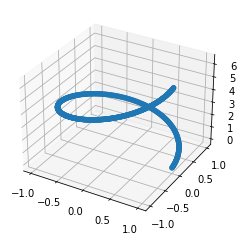

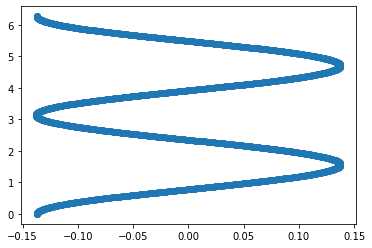

In [87]:
psi_l_0 = psi_l[:,1]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], t)
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
for i in range(psi_l.shape[1]):
    ax.scatter(psi_l[:,i], t)
    plt.show()

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import eigh
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings


In [34]:
def find_diffusion_matrix(X=None, alpha=0.15):
    dists = euclidean_distances(X, X)
    K = np.exp(-dists**2 / alpha)

    r = np.sum(K, axis=0)
    Di = np.diag(1/r)
    P = np.matmul(Di, K)

    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))

    return P_prime, P, Di, K, D_left

In [30]:
def find_diffusion_map(P_prime, D_left, n_eign=3):
    """Function to find the diffusion coordinates in the diffusion space

        >Parameters:
        P_prime - Symmetrized version of Diffusion Matrix P
        D_left - D^{-1/2} matrix
        n_eigen - Number of eigen vectors to return. This is effectively
                    the dimensions to keep in diffusion space.

        >Returns:
        Diffusion_map as np.array object
    """
    n_eign = n_eign

    eigenValues, eigenVectors = eigh(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    diffusion_coordinates = np.matmul(D_left, eigenVectors)

    return diffusion_coordinates[:,:n_eign]

In [78]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(x, eps)
diff_coords = find_diffusion_map(P_prime, D_left, n_eign=3)
diff_coords

array([[-3.33739322e-03, -3.03433081e-05, -4.72604471e-03],
       [-3.33739322e-03, -6.06843492e-05, -4.72576627e-03],
       [-3.33739322e-03, -9.10208601e-05, -4.72530222e-03],
       ...,
       [-3.33739322e-03,  9.10208601e-05, -4.72530222e-03],
       [-3.33739322e-03,  6.06843492e-05, -4.72576627e-03],
       [-3.33739322e-03,  3.03433081e-05, -4.72604471e-03]])

In [37]:
def plot_3Dfigure(newX, title='Datapoints'):
    data = go.Scatter3d(x=newX[:,0], y=newX[:,1], z=newX[:,2], mode='markers', marker=dict(
            size=2,color=newX[:,1],opacity=0.7,colorscale='Viridis'))
    layout = go.Layout(title_text=title,title_x=0.5,title_y=0.8,title_font_size=12)
    fig = go.Figure(data=[data], layout=layout)
    fig.update_layout(showlegend=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(scene = dict(
                    xaxis = dict(title= '', ticks= '', showticklabels= False,),
                    yaxis = dict(title= '', ticks= '', showticklabels= False,),
                    zaxis = dict(title= '', ticks= '', showticklabels= False,),
                    ))

    fig.show()


In [43]:
newX = np.array([x[:,0], x[:,1], t])
plot_3Dfigure(newX.T, title='Synthetic 3D Datapoints')

(1000, 3)


In [53]:
def plot_2Dsub_figures(d_map, t, alpha_values, title='Diffused points'):
    fig = make_subplots(rows=1, cols=1,subplot_titles="ciao")
    fig.add_trace(
        go.Scatter(x=d_map, y=t, mode='markers', marker=dict(
        size=3,color=t,opacity=0.8,colorscale='Viridis')),row=1, col=1)

    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(height=500, width=1000, showlegend=False)
    fig.show()

In [56]:
for i in range(diff_coords.shape[1]):
    plot_2Dsub_figures(diff_coords[:,i], t, eps)